unzip

In [ ]:
import os
import zipfile
zip_file_name = "stroke-ct.zip"

folder_path = '/content/drive/MyDrive/StrokeCTjune'
zip_file_path = '/content/drive/MyDrive/stroke-ct.zip'

# Create the folder if it doesn't exist
import os
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")

# Unzip the file into the new folder
import zipfile
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(folder_path)
    print(f"Successfully unzipped {zip_file_path} into {folder_path}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
except zipfile.BadZipFile:
    print(f"Error: {zip_file_path} is not a valid zip file")
except Exception as e:
    print(f"An error occurred: {e}")


Folder '/content/drive/MyDrive/StrokeCTjune' created.
Successfully unzipped /content/drive/MyDrive/stroke-ct.zip into /content/drive/MyDrive/StrokeCTjune


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [ ]:

stroke_paths = glob("/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke/*.jpg")  # or *.png
normal_paths = glob("/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Normal/*.jpg")

print("Stroke images:", len(stroke_paths))
print("Normal images:", len(normal_paths))


Stroke images: 950
Normal images: 1551


# Visualization:

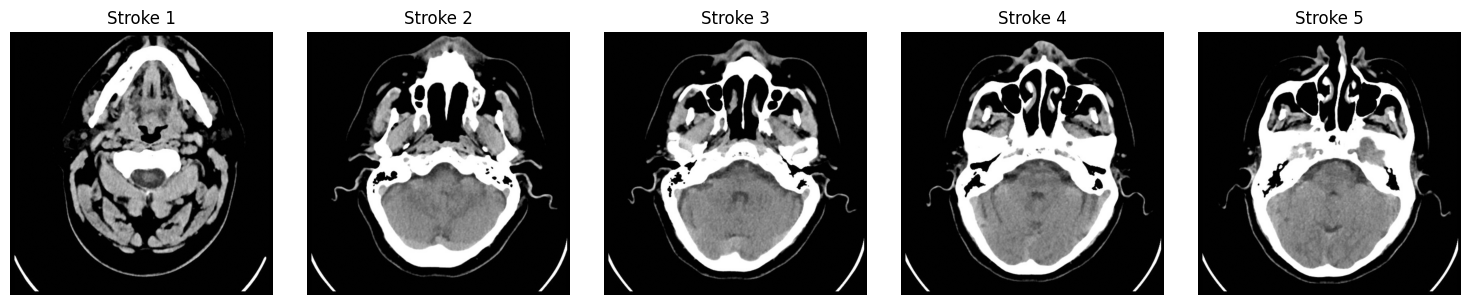

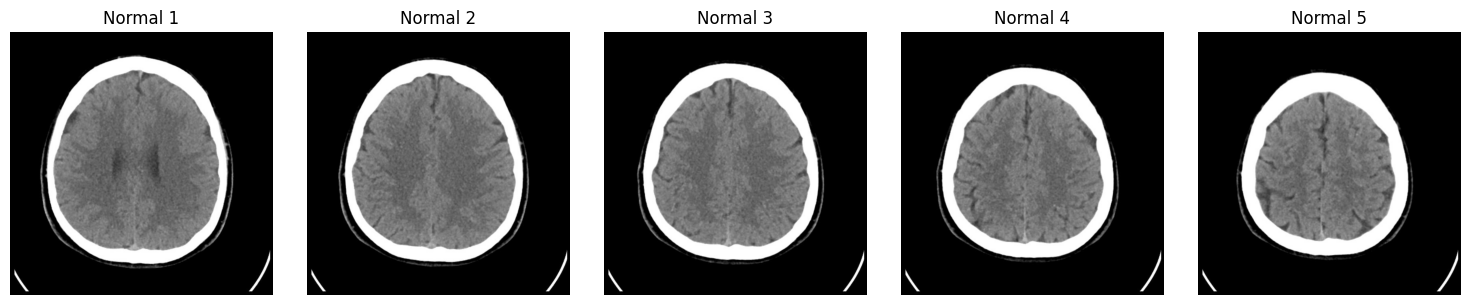

In [ ]:
def show_images(paths, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = cv2.imread(paths[i], cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(stroke_paths, "Stroke")
show_images(normal_paths, "Normal")


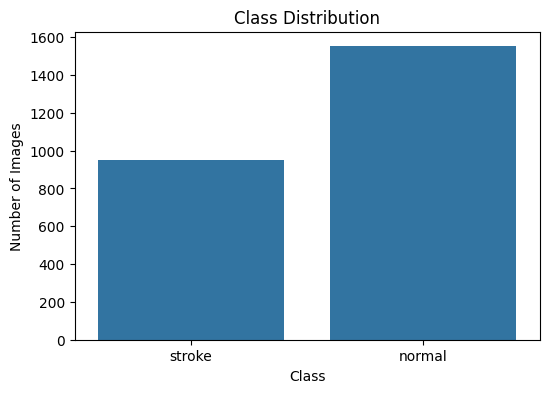

In [ ]:
import matplotlib.pyplot as plt

labels = ['stroke'] * len(stroke_paths) + ['normal'] * len(normal_paths)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


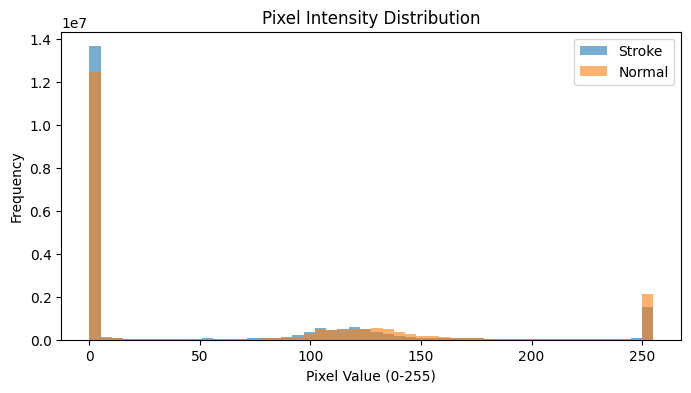

In [ ]:
def plot_pixel_histogram(paths, label, sample_size=50):
    pixels = []
    for path in paths[:sample_size]:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        pixels.extend(img.ravel())

    plt.hist(pixels, bins=50, alpha=0.6, label=label)

plt.figure(figsize=(8, 4))
plot_pixel_histogram(stroke_paths, "Stroke")
plot_pixel_histogram(normal_paths, "Normal")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Calculate aspect ratio

In [ ]:
def aspect_ratios(paths):
    ratios = []
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            h, w = img.shape
            ratios.append(w / h)
    return ratios

stroke_ratios = aspect_ratios(stroke_paths)
normal_ratios = aspect_ratios(normal_paths)

plt.figure(figsize=(8, 4))
sns.histplot(stroke_ratios, label='Stroke', color='red', kde=True)
sns.histplot(normal_ratios, label='Normal', color='green', kde=True)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.legend()
plt.show()


Blur Detection (Image Quality Check)

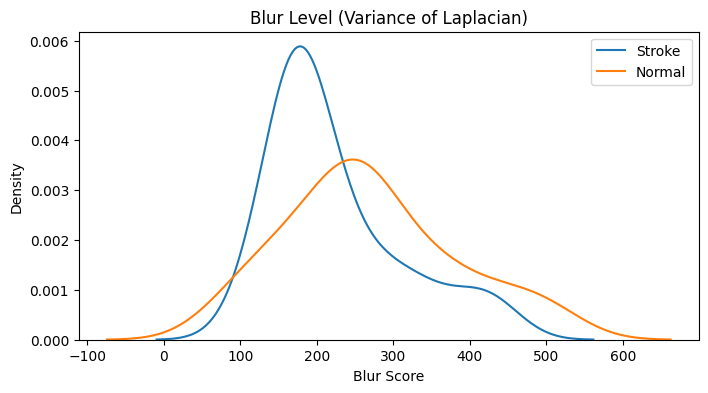

In [ ]:
def calculate_blur(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

stroke_blur = [calculate_blur(p) for p in stroke_paths[:50]]
normal_blur = [calculate_blur(p) for p in normal_paths[:50]]

plt.figure(figsize=(8, 4))
sns.kdeplot(stroke_blur, label='Stroke')
sns.kdeplot(normal_blur, label='Normal')
plt.title("Blur Level (Variance of Laplacian)")
plt.xlabel("Blur Score")
plt.legend()
plt.show()


# preprocessing:

1. CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [ ]:
def preprocess_clahe(path, size=224):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = img / 255.0
    return img


In [ ]:
IMG_SIZE = 224

X = []
y = []
for path in tqdm(stroke_paths):
    X.append(preprocess_clahe(path))
    y.append(1)
for path in tqdm(normal_paths):
    X.append(preprocess_clahe(path))
    y.append(0)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


100%|██████████| 1551/1551 [00:10<00:00, 149.45it/s]


X shape: (2501, 224, 224, 1)
y shape: (2501,)


In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0])

# Data Augmentation

<ipython-input-10-3208669074>:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(0, 0.02*255*255), p=1.0) # Equivalent to iaa.AdditiveGaussianNoise(scale=(0, 0.02*255)), var_limit is variance


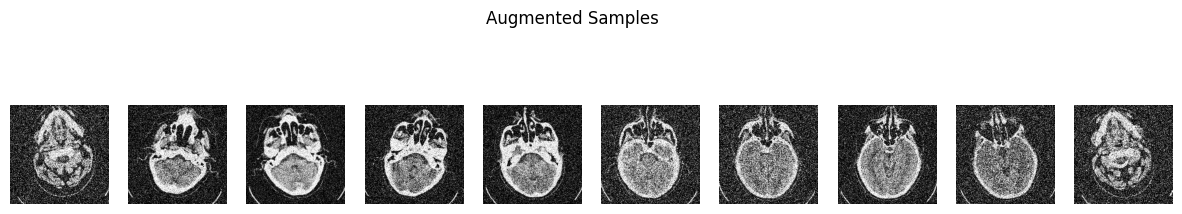

In [ ]:
import albumentations as A

# Define an Albumentations augmentation sequence
# Albumentations uses a different syntax and set of augmentations
augment = A.Compose([
    A.HorizontalFlip(p=0.5), # Equivalent to iaa.Fliplr(0.5)
    A.Rotate(limit=10, p=1.0), # Equivalent to iaa.Affine(rotate=(-10, 10)), limit is the maximum rotation in degrees
    A.RandomGamma(gamma_limit=(80, 120), p=1.0), # Equivalent to iaa.GammaContrast((0.8, 1.2)), gamma_limit is in percentage
    A.GaussNoise(var_limit=(0, 0.02*255*255), p=1.0) # Equivalent to iaa.AdditiveGaussianNoise(scale=(0, 0.02*255)), var_limit is variance
])

# Example: augment a batch
# Convert the preprocessed images back to uint8 [0, 255] for Albumentations
sample_images_uint8 = (X[:10] * 255).astype(np.uint8).squeeze() # Remove the channel dimension for grayscale

augmented_images = []
for img in sample_images_uint8:
    augmented_img = augment(image=img)['image']
    augmented_images.append(augmented_img)

# Convert back to numpy array
augmented_images = np.array(augmented_images)

# visualize augmented
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    # Add the channel dimension back for plotting if needed, although imshow handles it
    plt.imshow(augmented_images[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Samples")
plt.show()

In [ ]:
len(augmented_images)

10

In [ ]:
stroke_dir = '/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke/'
stroke_images = os.listdir(stroke_dir)

len(stroke_images)

950

In [ ]:
import albumentations as A
import cv2
import os
from tqdm import tqdm

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=1.0),
    A.RandomGamma(gamma_limit=(80, 120), p=1.0),
    A.GaussNoise(var_limit=(10.0, 50.0), p=1.0)
])



stroke_dir = '/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke'
aug_save_dir = '/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/stroke_aug'
os.makedirs(aug_save_dir, exist_ok=True)

stroke_images = os.listdir(stroke_dir)
needed = len(normal_paths) - len(stroke_images)

for i in tqdm(range(needed)):
    img_name = stroke_images[i % len(stroke_images)]
    img_path = os.path.join(stroke_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Failed to load image: {img_path}")
        continue

    augmented = augment(image=img)['image']
    save_path = os.path.join(aug_save_dir, f"aug_{i}_{img_name}")
    cv2.imwrite(save_path, augmented)


<ipython-input-13-1657132320>:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0)
100%|██████████| 601/601 [00:17<00:00, 33.85it/s]


In [ ]:
needed = len(normal_paths) - len(stroke_images)
print(f"Number of augmented images needed: {needed}")

Number of augmented images needed: 601


In [ ]:
import shutil

for file in os.listdir(aug_save_dir):
    shutil.move(os.path.join(aug_save_dir, file), stroke_dir)


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_dataset_dir = '/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/'

val_ratio = 0.15
test_ratio = 0.15
train_ratio = 1.0 - val_ratio - test_ratio

base_output_dir = 'dataset_split'
splits = ['train', 'val', 'test']
classes = ['Stroke', 'Normal']

for split in splits:
    for cls in classes:
        split_dir = os.path.join(base_output_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)

for cls in classes:
    cls_path = os.path.join(original_dataset_dir, cls)
    images = os.listdir(cls_path)
    images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Train + Temp
    train_imgs, temp_imgs = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=42)

    # Val + Test
    val_size = val_ratio / (val_ratio + test_ratio)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(1 - val_size), random_state=42)


    for img in train_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(base_output_dir, 'train', cls, img))
    for img in val_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(base_output_dir, 'val', cls, img))
    for img in test_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(base_output_dir, 'test', cls, img))

print("successfully✅ ")


successfully✅ 


# Model

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [ ]:

#  Configuration
DATA_DIR = "/content/dataset_split"
BATCH_SIZE = 16
IMG_SIZE = 224
EPOCHS = 50
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2


In [ ]:

#  Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ConvNeXt normalization
                         [0.229, 0.224, 0.225])
])


In [ ]:

#   Dataset & DataLoader
train_data = ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
val_data = ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


# **ConvNext model**

In [ ]:

weights = ConvNeXt_Base_Weights.DEFAULT
model = convnext_base(weights=weights)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, NUM_CLASSES)  # Change head
model = model.to(DEVICE)


In [ ]:

#   Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)


In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct_train, total_train = 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")


Epoch 1/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 1: Train Loss = 0.4576, Train Acc = 0.7664, Val Loss = 0.2035, Val Acc = 0.9099


Epoch 2/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 2: Train Loss = 0.1957, Train Acc = 0.9175, Val Loss = 0.1032, Val Acc = 0.9678


Epoch 3/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 3: Train Loss = 0.0660, Train Acc = 0.9756, Val Loss = 0.0963, Val Acc = 0.9764


Epoch 4/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 4: Train Loss = 0.0329, Train Acc = 0.9889, Val Loss = 0.0769, Val Acc = 0.9721


Epoch 5/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 5: Train Loss = 0.0552, Train Acc = 0.9774, Val Loss = 0.0957, Val Acc = 0.9657


Epoch 6/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 6: Train Loss = 0.0312, Train Acc = 0.9922, Val Loss = 0.0436, Val Acc = 0.9828


Epoch 7/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 7: Train Loss = 0.0411, Train Acc = 0.9889, Val Loss = 0.0642, Val Acc = 0.9721


Epoch 8/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 8: Train Loss = 0.0233, Train Acc = 0.9922, Val Loss = 0.0570, Val Acc = 0.9828


Epoch 9/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 9: Train Loss = 0.0211, Train Acc = 0.9931, Val Loss = 0.0379, Val Acc = 0.9828


Epoch 10/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 10: Train Loss = 0.0212, Train Acc = 0.9926, Val Loss = 0.0598, Val Acc = 0.9850


Epoch 11/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 11: Train Loss = 0.0045, Train Acc = 0.9986, Val Loss = 0.0222, Val Acc = 0.9957


Epoch 12/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 12: Train Loss = 0.0280, Train Acc = 0.9889, Val Loss = 0.0541, Val Acc = 0.9850


Epoch 13/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 13: Train Loss = 0.0101, Train Acc = 0.9972, Val Loss = 0.0628, Val Acc = 0.9828


Epoch 14/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 14: Train Loss = 0.0061, Train Acc = 0.9977, Val Loss = 0.0631, Val Acc = 0.9828


Epoch 15/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 15: Train Loss = 0.0175, Train Acc = 0.9935, Val Loss = 0.0776, Val Acc = 0.9807


Epoch 16/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 16: Train Loss = 0.0148, Train Acc = 0.9963, Val Loss = 0.0189, Val Acc = 0.9871


Epoch 17/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 17: Train Loss = 0.0204, Train Acc = 0.9926, Val Loss = 0.0261, Val Acc = 0.9914


Epoch 18/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 18: Train Loss = 0.0083, Train Acc = 0.9986, Val Loss = 0.0779, Val Acc = 0.9742


Epoch 19/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 19: Train Loss = 0.0055, Train Acc = 0.9982, Val Loss = 0.0285, Val Acc = 0.9957


Epoch 20/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 20: Train Loss = 0.0059, Train Acc = 0.9986, Val Loss = 0.0482, Val Acc = 0.9893


Epoch 21/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 21: Train Loss = 0.0032, Train Acc = 0.9986, Val Loss = 0.0595, Val Acc = 0.9871


Epoch 22/50: 100%|██████████| 136/136 [01:43<00:00,  1.31it/s]


Epoch 22: Train Loss = 0.0218, Train Acc = 0.9922, Val Loss = 0.0826, Val Acc = 0.9700


Epoch 23/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 23: Train Loss = 0.0261, Train Acc = 0.9903, Val Loss = 0.0870, Val Acc = 0.9785


Epoch 24/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 24: Train Loss = 0.0218, Train Acc = 0.9917, Val Loss = 0.0410, Val Acc = 0.9893


Epoch 25/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 25: Train Loss = 0.0117, Train Acc = 0.9954, Val Loss = 0.0629, Val Acc = 0.9893


Epoch 26/50: 100%|██████████| 136/136 [01:43<00:00,  1.31it/s]


Epoch 26: Train Loss = 0.0385, Train Acc = 0.9862, Val Loss = 0.0269, Val Acc = 0.9893


Epoch 27/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 27: Train Loss = 0.0108, Train Acc = 0.9963, Val Loss = 0.0602, Val Acc = 0.9807


Epoch 28/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 28: Train Loss = 0.0093, Train Acc = 0.9963, Val Loss = 0.0545, Val Acc = 0.9785


Epoch 29/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 29: Train Loss = 0.0032, Train Acc = 0.9991, Val Loss = 0.0358, Val Acc = 0.9850


Epoch 30/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 30: Train Loss = 0.0160, Train Acc = 0.9949, Val Loss = 0.0488, Val Acc = 0.9871


Epoch 31/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 31: Train Loss = 0.0079, Train Acc = 0.9963, Val Loss = 0.0348, Val Acc = 0.9936


Epoch 32/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 32: Train Loss = 0.0005, Train Acc = 1.0000, Val Loss = 0.0387, Val Acc = 0.9914


Epoch 33/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 33: Train Loss = 0.0007, Train Acc = 0.9995, Val Loss = 0.0362, Val Acc = 0.9893


Epoch 34/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 34: Train Loss = 0.0001, Train Acc = 1.0000, Val Loss = 0.0319, Val Acc = 0.9914


Epoch 35/50: 100%|██████████| 136/136 [01:43<00:00,  1.31it/s]


Epoch 35: Train Loss = 0.0002, Train Acc = 1.0000, Val Loss = 0.0543, Val Acc = 0.9850


Epoch 36/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 36: Train Loss = 0.0037, Train Acc = 0.9991, Val Loss = 0.0490, Val Acc = 0.9850


Epoch 37/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 37: Train Loss = 0.0003, Train Acc = 1.0000, Val Loss = 0.0360, Val Acc = 0.9914


Epoch 38/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 38: Train Loss = 0.0138, Train Acc = 0.9968, Val Loss = 0.0246, Val Acc = 0.9936


Epoch 39/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 39: Train Loss = 0.0382, Train Acc = 0.9857, Val Loss = 0.0701, Val Acc = 0.9785


Epoch 40/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 40: Train Loss = 0.0084, Train Acc = 0.9986, Val Loss = 0.0338, Val Acc = 0.9893


Epoch 41/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 41: Train Loss = 0.0059, Train Acc = 0.9982, Val Loss = 0.1811, Val Acc = 0.9592


Epoch 42/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 42: Train Loss = 0.0012, Train Acc = 1.0000, Val Loss = 0.0422, Val Acc = 0.9893


Epoch 43/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 43: Train Loss = 0.0002, Train Acc = 1.0000, Val Loss = 0.0399, Val Acc = 0.9871


Epoch 44/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 44: Train Loss = 0.0001, Train Acc = 1.0000, Val Loss = 0.0382, Val Acc = 0.9893


Epoch 45/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 45: Train Loss = 0.0053, Train Acc = 0.9972, Val Loss = 0.0452, Val Acc = 0.9914


Epoch 46/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 46: Train Loss = 0.0013, Train Acc = 0.9995, Val Loss = 0.0553, Val Acc = 0.9850


Epoch 47/50: 100%|██████████| 136/136 [01:44<00:00,  1.31it/s]


Epoch 47: Train Loss = 0.0329, Train Acc = 0.9894, Val Loss = 0.0506, Val Acc = 0.9871


Epoch 48/50: 100%|██████████| 136/136 [01:43<00:00,  1.31it/s]


Epoch 48: Train Loss = 0.0176, Train Acc = 0.9945, Val Loss = 0.0440, Val Acc = 0.9828


Epoch 49/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 49: Train Loss = 0.0087, Train Acc = 0.9968, Val Loss = 0.0662, Val Acc = 0.9850


Epoch 50/50: 100%|██████████| 136/136 [01:44<00:00,  1.30it/s]


Epoch 50: Train Loss = 0.0038, Train Acc = 0.9986, Val Loss = 0.0362, Val Acc = 0.9871


In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, '/content/drive/MyDrive/model_checkpoint.pth')


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1


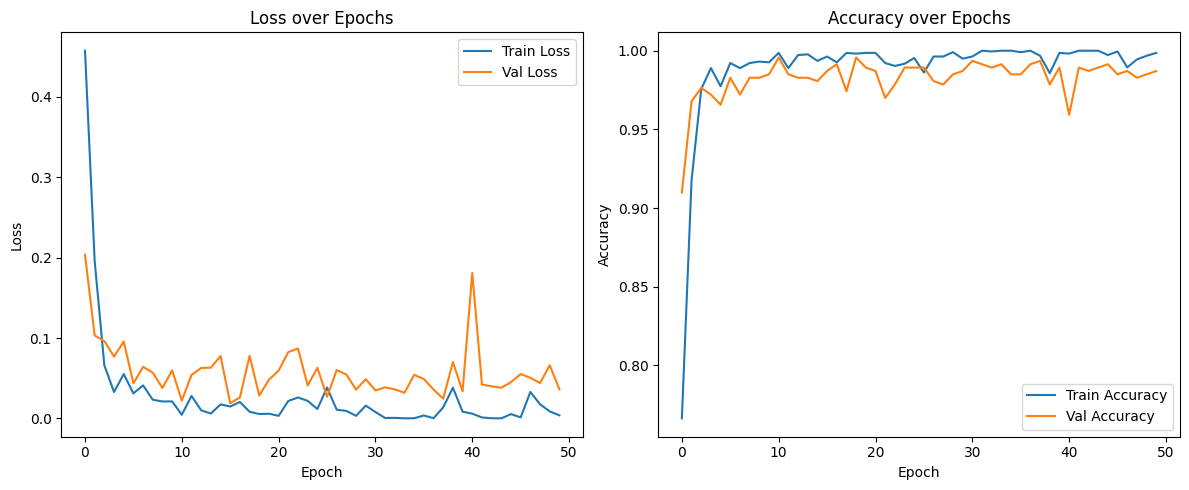

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
plt.savefig('/content/drive/MyDrive/loss_accuracy_plot.png')


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())



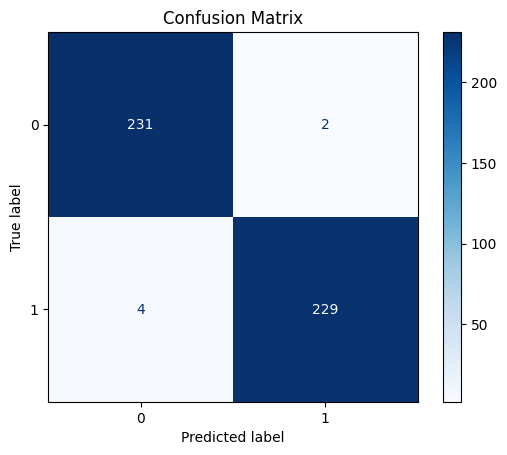

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       233
           1       0.99      0.98      0.99       233

    accuracy                           0.99       466
   macro avg       0.99      0.99      0.99       466
weighted avg       0.99      0.99      0.99       466



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))


# **Testing & Prediction**

In [ ]:
from torchvision import transforms
from PIL import Image
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)  # get class index
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
class_names = ['Normal', 'Brain Stroke']


In [ ]:


# Load and preprocess image
img = Image.open('/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Normal/100 (1).jpg').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # match your training input size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # adjust for your dataset
])
img_tensor = transform(img).unsqueeze(0).to(DEVICE)  # add batch dim

# Predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, predicted_class = torch.max(output, 1)
predicted_index = predicted_class.item()
predicted_label = class_names[predicted_index]

print(f"Predicted class index: {predicted_index}")
print(f"Predicted diagnosis: {predicted_label}")


Predicted class index: 0
Predicted diagnosis: Normal


In [ ]:


# Load and preprocess image
img = Image.open('/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke/58 (10).jpg').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # match your training input size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # adjust for your dataset
])
img_tensor = transform(img).unsqueeze(0).to(DEVICE)  # add batch dim

# Predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, predicted_class = torch.max(output, 1)

predicted_index = predicted_class.item()
predicted_label = class_names[predicted_index]

print(f"Predicted class index: {predicted_index}")
print(f"Predicted diagnosis: {predicted_label}")


Predicted class index: 1
Predicted diagnosis: Brain Stroke
